## 单机多卡

&emsp;&emsp;一台机器可以安装多个GPU(1-16)，在训练和预测的时候，我们将一个小批量计算切分到多个GPU上来加速。常用的切分方案有：

1. **数据并行**：将小批量分成n块，每个GPU拿到完整参数，计算这一块数据的梯度，之后将各个小批量的梯度加和在一起。
2. **模型并行**：将模型分成n块，每个GPU拿到一块模型计算它的前向和方向结果。比如有一个100层的残差网络，有两块GPU的话，那就是第0块GPU拿到前面50层，第一块GPU拿到后面50层。这种方式主要是用于模型在单GPU放不下的情况。
3. **通道并行(数据+模型并行)**：

1. 小批量分到多GPU计算后，模型结果通常是通过梯度的方式合并在一起。模型只有一份。
2. 数据拆分并行之后，中间需要存储的东西需要增加模型和梯度，因为需要将模型拷贝到各个GPU上，由于Batch_Size也会变小，所以，**性能会有所损失**。

## 多GPU训练实现

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import d2l.torch as d2l

In [2]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat
loss = nn.CrossEntropyLoss(reduction='none')

### 向多个设备分发参数

&emsp;&emsp;给定的只有一个模型的参数，它存在于主内存中。在多`GPU`训练的时候，我们需要将参数挪动到`GPU`上才能做计算。`get_params`函数是说给定参数和设备，然后将参数放到某个设备上去。

In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [4]:
new_params = get_params(params, d2l.try_gpu(0))  # 尝试将参数放在GPU 0上面。
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
b1 grad: None


### allreduce 函数将所有向量相加

&emsp;&emsp;将所有GPU上的data累加起来汇总。比如有4块GPU，将1，2，3块GPU的梯度信息发送到第0块GPU上，计算完成后，再将计算结果再发送回各个GPU上。

In [5]:
def allreduce(data):
    for i in range(1, len(data)):  # 汇总梯度信息
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):  # 分发梯度信息
        data[i] = data[0].to(data[i].device)

In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]]) 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]]) 
 tensor([[3., 3.]])


### 小批量数据均匀分布在多个GPU上

In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

AttributeError: module 'torch._C' has no attribute '_scatter'

&emsp;&emsp;如果数据不能被整除的话，那么最后一个GPU得到的数据就会少一点。

In [8]:
def split_batch(X, y, devices):
    """将`X`和`y`拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

### 在一个小批量上实现多GPU训练

In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到`num_gpus`个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU 0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...


/Users/hezhiqiang01/Desktop/anaconda/anaconda3/envs/ACG/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370253951/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


ValueError: Expected a non cpu device, but got: cpu

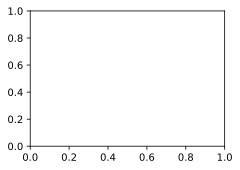

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

ValueError: Expected a non cpu device, but got: cpu

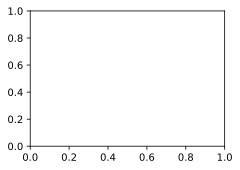

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

### 多GPU的简洁实现

In [17]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的 ResNet-18 模型。"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层。
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [18]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

In [19]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个 GPU 上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

KeyboardInterrupt: 

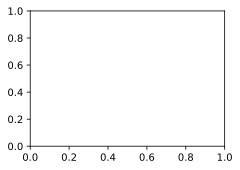

In [20]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [ ]:
train(net, num_gpus=2, batch_size=512, lr=0.2)

## 分布式

数据并行的分布式和单机多卡的方式并没有本质的区别。

分布式系统中，数据是放在分布式文件系统上。所有的机器都可以分开读取存放在不同磁盘上的样本。有多台机器、每台机器里面有多个GPU，每个机器叫做worker。

对于多个worker首先需要读取数据，与之前不同的是，现在是通过网络将数据读取进来。收发梯度的时候也是通过网络，从一台机器上跑到另外一台机器上。

- [http://zh-v2.d2l.ai/chapter_computational-performance/parameterserver.html](http://zh-v2.d2l.ai/chapter_computational-performance/parameterserver.html)

分布式同步数据并行是多`GPU`数据并行在多台机器上的扩展，网络通讯通常是瓶颈。为了考虑通信，往往采用大的`Batch_Size`，需要注意使用特别大的批量大小时，同时要考虑收敛效率。